## 샤프 지수(Sharpe Ratio) 이용한 포트폴리오 최적화
- 위험 대비 성과 측정 지표
- Sharpe = (포트폴리오 평균 수익률 - 무위험 이자율) / 포트폴리오 수익률 표준편차

### 개별 종목 머지

In [2065]:
import pandas as pd
from pykrx import stock


In [2066]:
start_date = f'20220101'
end_date = f'20231231'

symbols = [ '035420', '196170', '042700', '005930'] # 네이버, 알트로젠, 한미반도체, 삼성전자

In [2067]:
# dataframe concat
stock_df = pd.DataFrame()
for symbol in symbols:
    stock_df[symbol] = stock.get_market_ohlcv_by_date(start_date, end_date, symbol)['종가'] # 네이버

stock_df

,035420,196170,042700,005930
날짜,,,,
2022-01-03,376000,62226,19075,78600
2022-01-04,365500,60140,18625,78700
2022-01-05,355000,58472,18000,77400
2022-01-06,338500,58555,17500,76900
2022-01-07,338000,59306,18000,78300
...,...,...,...,...
2023-12-21,216500,88100,59200,75000
2023-12-22,215000,87900,58600,75900
2023-12-26,215500,91900,57600,76600


In [2068]:
# 데일리 수익률
daily_return = stock_df.pct_change(periods=1) # shift and percent 까지 해서 수익률 나옴.
daily_return

,035420,196170,042700,005930
날짜,,,,
2022-01-03,NaN,NaN,NaN,NaN
2022-01-04,-0.027926,-0.033523,-0.023591,0.001272
2022-01-05,-0.028728,-0.027735,-0.033557,-0.016518
2022-01-06,-0.046479,0.001419,-0.027778,-0.006460
2022-01-07,-0.001477,0.012826,0.028571,0.018205
...,...,...,...,...
2023-12-21,-0.018141,0.210165,0.008518,0.002674
2023-12-22,-0.006928,-0.002270,-0.010135,0.012000
2023-12-26,0.002326,0.045506,-0.017065,0.009223


In [2069]:
# 리스크 점수 구하기 
annual_return = daily_return.mean() * 252
annual_return

035420   -0.199957
196170    0.447981
042700    0.773682
005930    0.023433
dtype: float64

In [2070]:
daily_cov = daily_return.cov()
daily_cov

,035420,196170,042700,005930
035420,0.000530,0.000309,0.000180,0.000151
196170,0.000309,0.001717,0.000213,0.000141
042700,0.000180,0.000213,0.001409,0.000180
005930,0.000151,0.000141,0.000180,0.000193


In [2071]:
annual_cov = daily_cov * 252
annual_cov

,035420,196170,042700,005930
035420,0.133467,0.077841,0.045385,0.038149
196170,0.077841,0.432791,0.053550,0.035591
042700,0.045385,0.053550,0.354968,0.045268
005930,0.038149,0.035591,0.045268,0.048534


### 비율 생성과 정규화 

In [2072]:
import numpy as np

In [2073]:
# 비율 랜덤 생성
weights = np.random.random(len(symbols))
weights, type(weights), weights.shape

(array([0.91435611, 0.56814948, 0.94622006, 0.86759578]), numpy.ndarray, (4,))

In [2074]:
# 비율 정규화 
weights = weights / np.sum(weights)
weights, type(weights), weights.shape, np.sum(weights)

(array([0.27738682, 0.17235864, 0.28705333, 0.26320121]),
 numpy.ndarray,
 (4,),
 0.9999999999999998)

In [2075]:
return_of_rate = np.dot(weights, annual_return)
return_of_rate, type(return_of_rate) # y축 값 수익률 

(0.2500038194184491, numpy.float64)

In [2076]:
np.dot(annual_cov, weights)

array([0.07350713, 0.12092665, 0.13562845, 0.04248502])

In [2077]:
np.dot(weights.T, np.dot(annual_cov, weights))

0.09134736864586204

In [2078]:
risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
risk, type(risk) # x축 값 리스크

(0.30223727209902823, numpy.float64)

In [2079]:
# 여러 포트폴리오 비율 적용
fiture_count = 10000
portfolio_return_of_rate = []
portfolio_risk = []
portfolio_weights = []
sharpe_ration = [] 

for num in range(fiture_count):
    weights = np.random.random(len(symbols))
    weights = weights / np.sum(weights)
    return_of_rate = np.dot(weights, annual_return) # y
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # x

    portfolio_return_of_rate.append(return_of_rate)
    portfolio_risk.append(risk)
    portfolio_weights.append(weights)
    sharpe_ration.append(return_of_rate / risk)



In [2080]:
# Convert Dataframe : Return of rate, Rist, weights
portfolio = {
    "Return_of_rate" : portfolio_return_of_rate,
    "Risk" : portfolio_risk,
    "Sharpe": sharpe_ration
}

for idx, symbol in enumerate(symbols):
    portfolio[symbol] =  [weight[idx] for weight in portfolio_weights]


df_portfolio = pd.DataFrame(portfolio)
df_portfolio.head()

,Return_of_rate,Risk,Sharpe,035420,196170,042700,005930
0,0.222376,0.319984,0.694961,0.156998,0.359012,0.108760,0.375230
1,0.408669,0.459538,0.889305,0.056534,0.630177,0.173708,0.139580
2,0.213431,0.333014,0.640906,0.267103,0.357364,0.130553,0.244980
3,0.108586,0.303418,0.357876,0.486572,0.190730,0.150449,0.172250
4,0.230498,0.302894,0.760986,0.117180,0.320111,0.129743,0.432966


In [2081]:
maxindex = df_portfolio['Sharpe'].idxmax()

In [2082]:
df_portfolio.iloc[maxindex] # 가장 좋은 포트폴리오 

Return_of_rate    0.630467
Risk              0.460865
Sharpe            1.368009
035420            0.019895
196170            0.289991
042700            0.650935
005930            0.039179
Name: 3844, dtype: float64

In [2083]:
# 위험도 감소
minindex = df_portfolio['Risk'].idxmin()
df_portfolio.iloc[minindex] # 가장 안전한 포트폴리오 

Return_of_rate    0.058664
Risk              0.221139
Sharpe            0.265280
035420            0.052307
196170            0.082670
042700            0.015752
005930            0.849271
Name: 6127, dtype: float64

In [2084]:
# max 수익률
maxindex_return = df_portfolio['Return_of_rate'].idxmax()
df_portfolio.iloc[maxindex_return] # 가장 안전한 포트폴리오 

Return_of_rate    0.724634
Risk              0.545295
Sharpe            1.328885
035420            0.010186
196170            0.072692
042700            0.896523
005930            0.020600
Name: 1379, dtype: float64

### Chart 작성

In [2085]:
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic) 
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

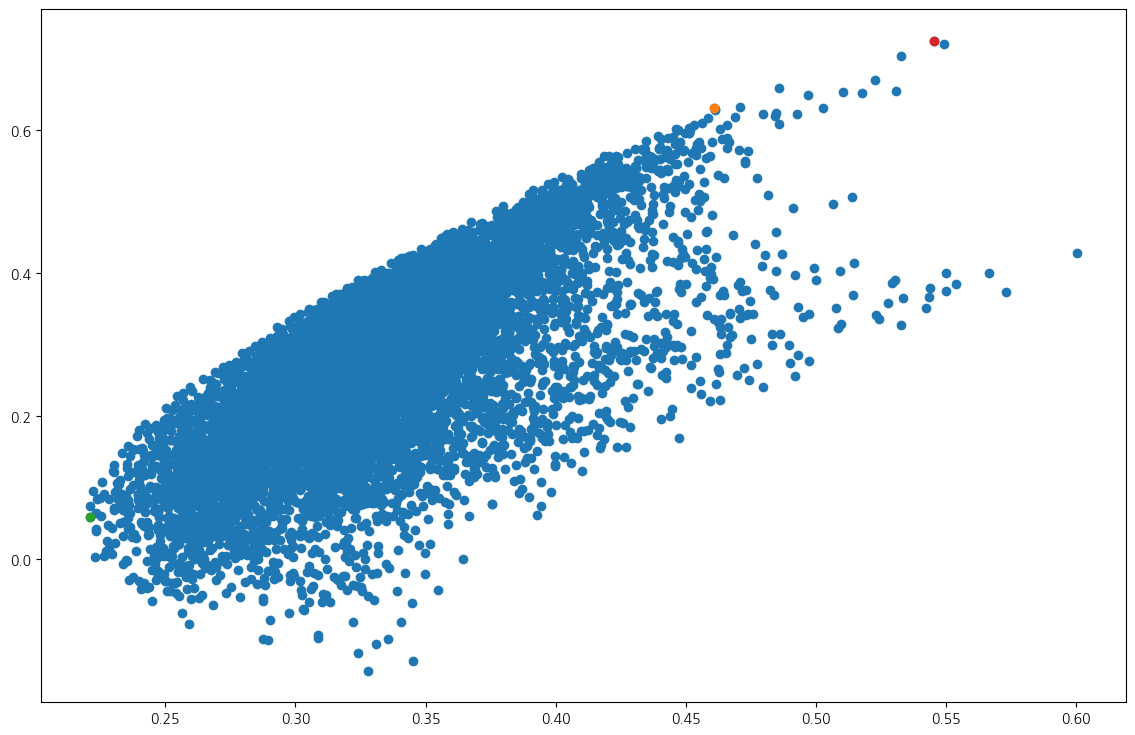

In [2086]:
plt.figure(figsize=(14,9), dpi=100)
plt.scatter(df_portfolio['Risk'], df_portfolio['Return_of_rate'])
plt.scatter(df_portfolio['Risk'].iloc[maxindex], df_portfolio['Return_of_rate'].iloc[maxindex])
plt.scatter(df_portfolio['Risk'].iloc[minindex], df_portfolio['Return_of_rate'].iloc[minindex])
plt.scatter(df_portfolio['Risk'].iloc[maxindex_return], df_portfolio['Return_of_rate'].iloc[maxindex_return])
plt.show()
# 최외곽에 가까운 지점의 weight 만큼 종목에 투자